<a href="https://colab.research.google.com/github/minhvvan/DeepLearning/blob/main/RecurrentNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=2, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self,x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m   #가중치에 대한 평균 그레이디언트 계산
    b_grad = np.sum(err) / m    #절편에 대한 평균 그레이디언트 계산
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1) #타겟을 열벡터로 변환
    y_val = y_val.reshape(-1,1) #val타겟을 열벡터로 변환
    m = len(x)
    self.w = np.ones((x.shape[1],1))  #가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  #가중치 기록

    for i in range(epochs):
      z = self.forpass(x) #정방향 계산
      a = self.activation(z) #활성화 함수
      err = -(y - a)
      w_grad, b_grad = self.backprop(x,err)  #역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  #그레이디언트 패널티적용
      self.w -= self.lr * w_grad  #가중치 업데이트
      self.b -= self.lr * b_grad  #절편 업데이트
      self.w_history.append(self.w.copy()) #가중치 기록
      a = np.clip(a, 1e-10,1-1e-10) #클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실과 규제 손실 적용
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  #검증

  
  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1,1))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)   #정방향 계산
    a = self.activation(z)  #활성화 함수
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) #로그 손실, 규제 손실 더하여 기록


In [3]:
class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units  #은닉층 뉴런 개수
    self.w1 = None  #은닉층 가중치
    self.b1 = None  #은닉층 절편
    self.w2 = None  #출력층 가중치
    self.b2 = None  #출력층 절편
    self.a1 = None  #은닉층 활성화 출력
    self.losses = []  #훈련 손실
    self.val_losses = []  #검승 손실
    self.lr = learning_rate #학습률
    self.l1 = l1  #l1 규제
    self.l2 = l2  #l2 규제

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1 #첫 번쨰 층 선형식 계산
    self.a1 = self.activation(z1) #활성화 함수
    z2 = np.dot(self.a1, self.w2) + self.b2 #두번째 선형식 계산

    return z2

  def backprop(self, x, err):
    m = len(x)  #샘플 개수
    w2_grad = np.dot(self.a1.T, err) / m  #출력층 그레이디언트
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)  #시그모이드 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m  #은닉층 그레이디언트
    b1_grad = np.sum(err_to_hidden) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_featuers):
    self.w1 = np.ones((n_featuers, self.units)) #(특성 개수, 은닉층 크기)
    self.b1 = np.zeros(self.units)  #은닉층 크기
    self.w2 = np.ones((self.units, 1)) #(은닉층 크기,1)
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1]) #가중치 초기화
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10,1-1e-10) #클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실 추가
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def training(self, x, y, m):
    z = self.forpass(x) #정방향 계산
    a = self.activation(z)  #활성화 함수
    err = -(y - a)  #오차 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    #그레이디언트 규제
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    #은닉층 가중치 절편 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    #출력층 가중치 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad

    return a

  def reg_loss(self):
    #은닉층과 출력층의 가중치에 규제 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [4]:
class RandomInitNetwork(DualLayer):
  def init_weights(self, n_featuers):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_featuers,self.units))  #(특성 개수, 은닉층 크기)
    self.b1 = np.zeros(self.units)  #은닉층 크기
    self.w2 = np.random.normal(0, 1, (self.units, 1))  #(은닉층 크기, 1)
    self.b2 = 0

In [5]:
class MinibatchNetwork(RandomInitNetwork):

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size  #배치 크기

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y_val = y_val.reshape(-1,1) #타깃 열 벡터로 변환
    self.init_weights(x.shape[1]) #은닉층과 출력층 가중치 초기화
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      for x_batch, y_batch in self.gen_batch(x, y):
        y_batch = y_batch.reshape(-1, 1)  #타깃 열 벡터로 변환
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10,1-1e-10) #클리핑
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)  #검증 손실 계산

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size  #미니 배치 횟수
    if length % self.batch_size:  #나누어 떨어지지 않으면 1추가
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))  #인덱스 셔플
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]  #batch_size만큼 슬라이싱하여 반환

In [6]:
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [7]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [8]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [9]:
for i in range(len(x_train_all)):
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [10]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [11]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
  print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [12]:
print(len(x_train_all[0]), len(x_train_all[1]))
print(y_train_all[:10])

59 32
[1 0 0 1 0 0 1 0 1 0]


In [13]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[[random_index[:20000]]]
y_train = y_train_all[[random_index[:20000]]]
x_val = x_train_all[[random_index[20000:]]]
y_val = y_train_all[[random_index[20000:]]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which 

In [14]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [15]:
print(x_train_seq.shape, x_val_seq.shape)
print(x_train_seq[0])

(20000, 100) (5000, 100)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [16]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [17]:
print(x_train_onehot.shape)
print(x_train_onehot.nbytes)

(20000, 100, 100)
800000000


In [38]:
class RecurrentNetwork(MinibatchNetwork):
  def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
    self.n_cells = n_cells  #셀 개수
    self.batch_size = batch_size #배치 크기
    self.w1h = None #은닉 상태에 대한 가중치
    self.w1x = None #입력에 대한 가중치
    self.b1 = None  #순환층의 절편
    self.w2 = None  #순환층의 가중치
    self.b2 = None  #출력층의 절편
    self.h = None #순환층의 활성화 출력
    self.losses = []  #훈련 손실
    self.val_losses = []  #검증 손실
    self.lr = learning_rate #학습률

  def init_weights(self, n_features, n_classes):
    orth_init = tf.initializers.Orthogonal()
    glorot_init = tf.initializers.GlorotUniform()

    self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()  #(셀 개수, 셀 개수)
    self.w1x = glorot_init((n_features, self.n_cells)).numpy()  #(특성 개수, 셀 개수)
    self.b1 = np.zeros(self.n_cells)  #은닉층의 크기
    self.w2 = glorot_init((self.n_cells, n_classes)).numpy()  #(셀 개수, 클래스 개수)
    self.b2 = np.zeros(n_classes)

  def forpass(self, x):
    self.h = [np.zeros((x.shape[0], self.n_cells))] #은닉 상태를 초기화
    seq = np.swapaxes(x, 0, 1)
    for x in seq:
      z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
      h = np.tanh(z1) #활성화 함수 적용
      self.h.append(h)  #역전파를 위한 은닉 상태 저장
      z2 = np.dot(h, self.w2) + self.b2 #출력층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)  #샘플 개수

    #출력층의 가중치와 절편에 대한 그레이디언트 계산
    w2_grad = np.dot(self.h[-1].T, err) / m
    b2_grad = np.sum(err) / m
    #배치 차원과 타임 스텝 차원 바꾸기
    seq = np.swapaxes(x, 0, 1)

    w1h_grad = w1x_grad = b1_grad = 0
    #셀 지전까지 그레이디언트 계산
    err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1]**2)
    #모든 타임 스텝을 거슬러 가며 그레이디언트 전파
    for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
      w1h_grad += np.dot(h.T, err_to_cell)
      w1x_grad += np.dot(x.T, err_to_cell)
      b1_grad += np.sum(err_to_cell, axis=0)
      #이전 타임 스텝의 셀 직전까지 그레이디언트 계산
      err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h**2)

    w1h_grad /= m
    w1x_grad /= m
    b1_grad /= m

    return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1) #타깃 열 벡터로 변환
    np.random.seed(42)
    self.init_weights(x.shape[2], y.shape[1]) #은닉층과 출력층 가중치 초기화
    for i in range(epochs):
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end=' ')
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10,1-1e-10) #클리핑
        loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
        batch_losses.append(loss)
      print( )
      self.losses.append(np.mean(batch_losses))
      self.update_val_loss(x_val, y_val)  #검증 손실 계산

  def training(self, x, y):
    m = len(x)
    z = self.forpass(x) #정방향 계산
    a = self.activation(z)  #활성화 함수
    err = -(y - a)  #오차 계산
    w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    #셀의 가중치와 절편을 업데이트
    self.w1h -= self.lr * w1h_grad
    self.w1x -= self.lr * w1x_grad
    self.b1 -= self.lr * b1_grad
    #출력층 가중치 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad

    return a

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)   #정방향 계산
    a = self.activation(z)  #활성화 함수
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append(val_loss)

In [39]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

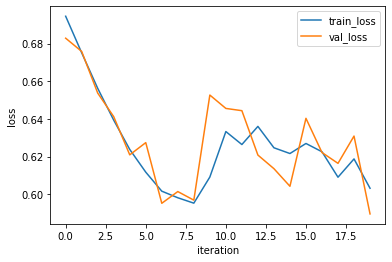

In [44]:
plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [42]:
rn.score(x_val_onehot, y_val)

0.686